In [1]:
# !pip install --upgrade dabest


In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors
import matplotlib as mpl
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from matplotlib.gridspec import GridSpecFromSubplotSpec
import seaborn as sns; sns.set()
from sklearn.preprocessing import MinMaxScaler
# import dabest


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def get_df(file_name, fly_number=0, group=None, time_exp = 180, threshold=[110, 130]):
    df = pd.read_hdf(file_name, header=[0, 1, 2], index_col=0)
    df.columns = df.columns.droplevel(0) # drop the top column

    # drop 'likelihood' columns
    col_drop = [v for i, v in enumerate(df.columns) if v[1] == 'likelihood']
    df.drop(col_drop, axis=1, inplace=True)

    def calculate_angle(point_a, point_b):
        '''
        Calculate angle btween two vectors:
        https://stackoverflow.com/questions/31735499/calculate-angle-clockwise-between-two-points
        '''
        ang_a = np.arctan2(*point_a[::-1])
        ang_b = np.arctan2(*point_b[::-1])
        return np.rad2deg((ang_a - ang_b) % (2 * np.pi))

    RH1 = (df['Head'] - df['Haustellum']).to_numpy() # Change Haustellum -> Rostrum: Rostrum to Head
    RH2 = (df['Rostrum'] - df['Haustellum']).to_numpy() #  Change Rostrum -> Haustellum: Rostrum to Haustellum

    # Not using:
    HR = (df['Haustellum'] - df['Rostrum']).to_numpy() # Haustellum to Rostrum
    HL = (df['Labella'] - df['Rostrum']).to_numpy() # Haustellum to Labella

    HRH = []
    RHL = []
    for i in range(len(df.index)):
        HRH.append(calculate_angle(RH2[i], RH1[i]))
        RHL.append(calculate_angle(HR[i], HL[i]))
    HRH = np.array(HRH)
    RHL = np.array(RHL)
    d = {
        'Rostrum': HRH,
        'Haustellum': RHL,
        'fly #': fly_number
         }
    ang_df = pd.DataFrame(d)
    ang_df['time'] = pd.to_timedelta(time_exp * df.index / len(df.index), unit='s')
    ang_df = ang_df.set_index('time', drop=True)
    ang_df = ang_df.resample('1000ms').mean()
    ang_df['PER'] = np.where((ang_df['Haustellum'] >= threshold[0]) & (ang_df['Rostrum'] >= threshold[1]), 1, 0)

    partial_thr = [75, 110, 110, 130]
    cond = ((ang_df['Haustellum'] >= partial_thr[0]) & (ang_df['Haustellum'] < partial_thr[2])) & \
    ((ang_df['Rostrum'] >= partial_thr[1]) & (ang_df['Rostrum'] < partial_thr[3]))

    ang_df.loc[cond, 'PER'] = 0.5
    ang_df.index = ang_df.index.astype(int) / 10e8
    ang_df['group'] = group
    return ang_df


In [4]:
# Put your file paths to analyze:

dlc_output_path = [
                    '/content/drive/My Drive/00_project/02_per/5_Gr64f_HisCl1_FLP/starved/experimental/data/deeplabcut/filtered/*',
                    '/content/drive/My Drive/00_project/02_per/5_Gr64f_HisCl1_FLP/starved/negative_control/data/deeplabcut/filtered/*'
                    # '/content/drive/My Drive/00_project/02_per/gr64f/GAL4/starved/60s-light-stimulation/{Gr64f}{+};{CsChri-tdT}{TM2}/negative-control/data/deeplabcut/filtered/*.h5',
                    # '/content/drive/My Drive/00_project/02_per/gr64f/GAL4/starved/60s-light-stimulation/{Gr64f}{+};{CsChri-tdT}{TM2}/experimental/data/deeplabcut/filtered/*.h5'

                    # '/content/drive/My Drive/00_project/02_per/gr66a/GAL4/fed/60s-light-stimulation/{Gr66a}{+};{CsChr-tdT}{TM2}/negative-control/data/deeplabcut/filtered/*.h5',
                    # '/content/drive/My Drive/00_project/02_per/gr66a/GAL4/fed/60s-light-stimulation/{Gr66a}{+};{CsChr-tdT}{TM2}/experimental/data/deeplabcut/filtered/*.h5'

                    # '/content/drive/My Drive/00_project/02_per/0_GRs/Balancers/{SP}{+};{Gr66aG4}{CsChr-mCh}/100msX6-light-stimulations/negative-control/data/deeplabcut/filtered/*.h5',
                    # '/content/drive/My Drive/00_project/02_per/0_GRs/Balancers/{SP}{+};{Gr66aG4}{CsChr-mCh}/100msX6-light-stimulations/{SP}{+};{Gr66aG4}{CsChr-mCh}/experimental/data/deeplabcut/filtered/*.h5'

                    # '/content/drive/My Drive/00_project/02_per/0_GRs/Balancers/{Gr43aG4}{+};{CsChr-mCh}{TM2}/negative-control/data/deeplabcut/filtered/*.h5',
                    # '/content/drive/My Drive/00_project/02_per/0_GRs/Balancers/{Gr43aG4}{+};{CsChr-mCh}{TM2}/experimental/data/deeplabcut/filtered/*.h5',

                #    '/content/drive/My Drive/00_project/02_per/0_GRs/Balancers/{Gr64fG4}{+};{Gr66aG4}{CsChr-mCherry}/100msX6-light-stimulations/{Gr64fG4}{+};{Gr66aG4}{CsChr-mCherry}/negative-control/data/deeplabcut/filtered/*.h5',
                #     '/content/drive/My Drive/00_project/02_per/0_GRs/Balancers/{Gr64fG4}{+};{Gr66aG4}{CsChr-mCherry}/100msX6-light-stimulations/{Gr64fG4}{+};{Gr66aG4}{CsChr-mCherry}/experimental/data/deeplabcut/filtered/*.h5',

                #    '/content/drive/My Drive/00_project/02_per/1_20G06/GAL4/{+}{+};{21D12G4}{CsChr-mCh}/negative-control/data/deeplabcut/filtered/*.h5',
                #    '/content/drive/My Drive/00_project/02_per/1_20G06/Split/{26A01AD}{+};{20G06DBD}{CChr-mCh-82182}/negative-control/data/deeplabcut/filtered/*.h5',
                #    '/content/drive/My Drive/00_project/02_per/1_20G06/Split/{10A11AD}{CsChr-mCh};{20G06DBD}{+}/negative-control/data/deeplabcut/filtered/*.h5',
                #    '/content/drive/My Drive/00_project/02_per/1_20G06/Split/{20G06AD}{+};{42E03DBD}{CsChr-mChr}/negative-control/data/deeplabcut/filtered/*.h5',
                # '/content/drive/My Drive/00_project/02_per/1_20G06/Split/{20G06AD}{+};{Ddc61H03DBD}{CChr-mCh-82182}/negative-control/data/deeplabcut/filtered/*.h5',




                    # '/content/drive/My Drive/00_project/02_per/0_GRs/Balancers/{Gr43aG4}{+};{CsChr-mCh}{TM2}/negative-control/data/deeplabcut/filtered/*.h5',

                #    '/content/drive/My Drive/01_paper/HisCl1/raw_data/figure_1/E/{Gr64fG4}{+};{CsChr-tdTomato}{+}/negative-control/data/deeplabcut/filtered/*.h5',
                #     '/content/drive/My Drive/00_project/02_per/gr64f/GAL4/starved/100ms_9900ms/{Gr64fG4}{+};{CsChr-mCherry}{TM2}/experimental/data/deeplabcut/filtered/*.h5' ,

                #    '/content/drive/My Drive/00_project/02_per/0_GRs/1sX6-lit/{Gr64fG4}{+};{CsChr-mCh}{+}/experimental/data/deeplabcut/filtered/*',

                    # '/content/drive/My Drive/00_project/02_per/gr64f/GAL4/starved/1s-light-stimulation/{Gr64f}{+};{CsChri-tdT}{TM2}/negative-control/data/deeplabcut/filtered/*.h5',
                    # '/content/drive/My Drive/00_project/02_per/gr64f/GAL4/starved/1s-light-stimulation/{Gr64f}{+};{CsChri-tdT}{TM2}/experimental/data/deeplabcut/filtered/*.h5'

                #    '/content/drive/My Drive/00_project/02_per/0_GRs/60s-lit/{Gr64fG4}{+};{CsChr-mCh}{+}/Batch_1/experimental/data/deeplabcut/filtered/*',

                #    '/content/drive/My Drive/00_project/02_per/2_HisCl1-/{Gr64fG4}{CsChr-mCh};{HisCl1-}{HisCl1-}/experimental/data/deeplabcut/filtered/*',
                #    '/content/drive/My Drive/00_project/02_per/2_HisCl1-/{Gr64fG4}{CsChr-mCh};{HisCl1-}{+}/experimental/data/deeplabcut/filtered/*',
                #    '/content/drive/My Drive/00_project/02_per/2_HisCl1-/{Gr64fG4}{CsChr-mCh};{+}{+}/experimental/data/deeplabcut/filtered/*',
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch2/control/fed/*',
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch2/53932/fed/*',
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch2/65941/fed/*',
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch2/53337/fed/*',
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch2/62428/fed/*',

                    # '/content/drive/My Drive/00_project/02_per/4_Ort_RNAi/starved/positive_control/*',
                    # '/content/drive/My Drive/00_project/02_per/4_Ort_RNAi/starved/experimental/*',

                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch2/control/starved/*',
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch2/53932/starved/*',
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch2/65941/starved/*',
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch2/53337/starved/*',
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch2/62428/starved/*',

                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/control/starved/*', # 1
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/53932/starved/*', # 2 HisCl1 VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/53337/starved/*', # 14 Clc-a VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/53356/starved/*', # 17 GluClalpha VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/58175/starved/*', # 6 Grd VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/65941/starved/*', # 15 CG6938 VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/28013/starved/*', # 11 HisCl1 VALIUM10
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/62428/starved/*', # 18 CG12344 VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/66973/starved/*', # 5 Clic VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/25826/starved/*', # 10 ClC-b VALIUM10
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/25854/starved/*', # 7 CG8916 VALIUM10
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/62282/starved/*', # 13 CG15270 VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/51877/starved/*', # 12 Clc-b VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/38384/starved/*', # 8 Grd VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/28650/starved/*', # 4 CG15270 VALIUM10
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/80400/starved/*', # 19 Best1 VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/26250/starved/*', # CG12344 VALIUM10
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/39031/starved/*', # 3 CG8916 VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/42654/starved/*', # 9 Best2 VALIUM20
                #    '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/RNAi-screening results/RNAi-data-batch1/27034/starved/*', # 16 ClC-c VALIUM10


                #    '/content/drive/My Drive/00_project/02_per/0_GRs/1sX6-lit/{Gr64fG4}{+};{CsChr-mCh}{+}/experimental/data/deeplabcut/filtered/*',
                #    '/content/drive/My Drive/00_project/02_per/2_HisCl1-/{Gr64fG4}{+};{CsChr-mCh}{+}/Batch_1/experimental/data/deeplabcut/filtered/*',
                   ]
# dlc_output_path = [FullPath+'*']


# category = ['+ ATR']
# category = ['-ATR', '+ATR']
# category = ['-TshGAL80', '+TshGAL80']

TimeExp = 180
dlc_output_path
len(dlc_output_path)

2

In [5]:
# Run this cell to generate dataframe from raw datas:
category = ['- ATR', '+ ATR']
category = ['+ ATR']
dlc_output_list = []

for path in dlc_output_path:
    dlc_output_list.append(glob.glob(path))

df_list = []
for j in range(len(dlc_output_path)):
    fnames = dlc_output_list[j]
    for i, fname in enumerate(fnames):
        df = get_df(fname, time_exp=TimeExp, fly_number=i+1, group='group_' + str(j+1))

        # Post-processing for dThata/Theta_0:
        R0 = df.Rostrum[0] # Theta_0
        delta_R = df.Rostrum - R0 # dTheta = Theta_t - Theta_0
        per_change =  delta_R / R0 # dTheta/Theta_0
        df['per_change'] = per_change


        df_list.append(df)

df = pd.concat(df_list)
df.reset_index(inplace=True)
# print(len(df['fly #'].unique()))
print(df['group'].unique())
print(df.shape)
df.head()



['group_1' 'group_2']
(3240, 7)


,time,Rostrum,Haustellum,fly #,PER,group,per_change
0,0.0,87.873112,67.826070,1.0,0.0,group_1,0.000000
1,1.0,87.471842,70.515913,1.0,0.0,group_1,-0.004566
2,2.0,80.900972,57.286116,1.0,0.0,group_1,-0.079343
3,3.0,80.840339,52.910632,1.0,0.0,group_1,-0.080033
4,4.0,111.078978,106.033179,1.0,0.5,group_1,0.264084


In [6]:

# df.pivot_table(index='time', columns=['group', 'fly #'], values='per_change').to_excel('/content/drive/My Drive/01_paper/HisCl1/raw_data/figure_S2/figS2A/figS2A.xlsx')

In [7]:
for i in df['group'].unique():
    print(df[df['group'] == i]['fly #'].max())

9.0
9.0


In [8]:
palette = sns.color_palette('flare_r', 20)

my_color_palette = {
                    'group_1': palette[16],
                    'group_2': palette[0],
                    'group_3': palette[1],
                    'group_4': palette[2],
                    'group_5': palette[3],
                    'group_6': palette[4],
                    'group_7': palette[5],
                    'group_8': palette[6],
                    'group_9': palette[7],
                    'group_10': palette[8],
                    'group_11': palette[9],
                    'group_12': palette[10],
                    'group_13': palette[11],
                    'group_14': palette[12],
                    'group_15': palette[13],
                    'group_16': palette[14],
                    'group_17': palette[15],
                    'group_18': palette[17],
                    'group_19': palette[18],
                    'group_20': palette[19],
                        }

palette = sns.color_palette('crest_r', 2)

my_color_palette = {
                    'group_1': palette[1],
                    'group_2': palette[0],
                        }

# palette = sns.color_palette('flare_r', 3)

# my_color_palette = {
#                     'group_1': palette[0],
#                     'group_2': palette[1],
#                     'group_3': palette[2],
#                         }

group_1


<ipython-input-11-b56c12463690>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(x='time',


group_2


<ipython-input-11-b56c12463690>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  sns.lineplot(x='time',


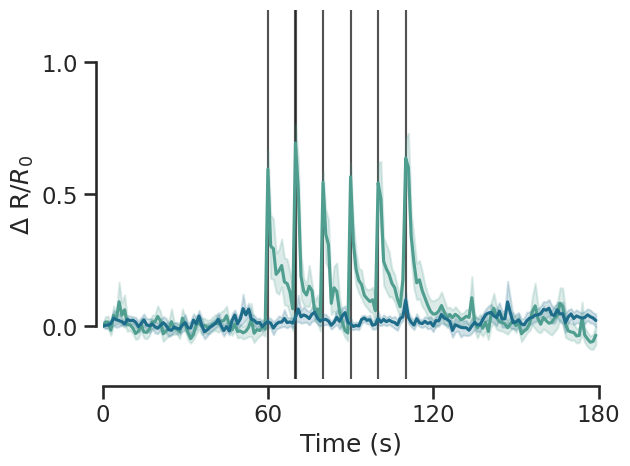

In [11]:
# For multiple single plots:

sns.set(style='ticks', context='talk')
fig, ax = plt.subplots()
for g in df.group.unique():
    print(g)
    plot_df = df[df['group']==g]

    # fig, ax = plt.subplots()

    color = my_color_palette[g]

    sns.lineplot(x='time',
                y='per_change',
                # hue='group',
                ci=68,
                # palette=color,
                color = color,
                legend=False,
                data=plot_df,
                ax=ax)


    # ax.axvspan(60, 120, 0, 1, alpha=0.1, color='k', zorder=0)
    for i in np.arange(60, 120, 10):
        ax.axvspan(i, i+0.1, 0, 1, alpha=0.5, color='k', zorder=0)


    ax.set(xlabel='Time (s)',
        ylabel= r'$\Delta$ R/$R_0$',
        xlim=[0, 180],
        ylim=[-0.2, 1.2]
        )

    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

    sns.despine(trim=True, offset=5)

    fig_title = g +'per_change'
    # base_path = '/content/drive/My Drive/00_project/02_per/2_HisCl1-/figures/'+ fig_title
    # base_path = '/content/drive/My Drive/00_project/02_per/gr64f/GAL4/starved/60s-light-stimulation/{Gr64f}{+};{CsChri-tdT}{TM2}/figures'+ fig_title
    base_path = '/content/drive/My Drive/00_project/02_per/5_Gr64f_HisCl1_FLP/figures/'+ fig_title
    fig_path = base_path + '.svg'

    if fig_path:
        plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

plt.show()

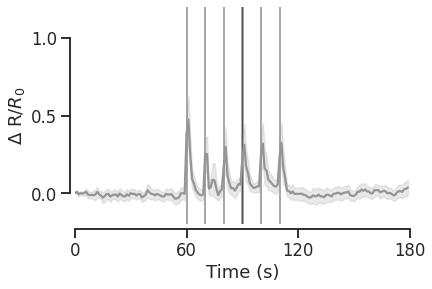

In [ ]:
sns.set(style='ticks', context='talk')

fig, ax = plt.subplots()

color = sns.color_palette("Greys", 1)

sns.lineplot(x='time',
             y='per_change',
             hue='group',
             ci=68,
             palette=color,
            #  color='k',
             legend=False,
             data=df, ax=ax)


# ax.axvspan(60, 120, 0, 1, alpha=0.1, color='k', zorder=0)
for i in np.arange(60, 120, 10):
    ax.axvspan(i, i+0.1, 0, 1, alpha=0.5, color='k',  zorder=0)


ax.set(xlabel='Time (s)',
       ylabel= r'$\Delta$ R/$R_0$',
       xlim=[0, 180],
       ylim=[-0.2, 1.2]
       )

ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.5))

sns.despine(trim=True, offset=5)

fig_title = g + 'constant_activation_per_change'
base_path = '/content/drive/My Drive/00_project/02_per/2_HisCl1-/figures/'+ fig_title
base_path = '/content/drive/My Drive/01_paper/HisCl1/raw_data/'+ fig_title
# base_path = '/content/drive/My Drive/00_project/02_per/gr64f/GAL4/starved/60s-light-stimulation/{Gr64f}{+};{CsChri-tdT}{TM2}/figures'+ fig_title
fig_path = base_path + '.svg'

if fig_path:
    plt.savefig(fig_path, transparent=True, dpi=600, bbox_inches='tight', pad_inches=0.0)

plt.show()

In [ ]:
# df4plot = df[(df['time'] >= 60) & (df['time'] < 120)].groupby(['group', 'fly #']).mean().reset_index().sort_values(['per_change'],ascending=False)
# df4plot = df[(df['time'] >= 60) & (df['time'] < 120)].groupby(['group']).mean().reset_index().sort_values(['per_change'],ascending=False)
# df4plot[df4plot['group'] == 'group_12']
df4plot

,group,time,Rostrum,Haustellum,fly #,PER,per_change
0,group_1,89.5,93.324286,67.473287,6.5,0.258333,0.222521
1,group_2,89.5,92.153333,67.302832,6.5,0.269444,0.164102
2,group_3,89.5,78.924964,69.034422,6.5,0.022222,0.002215


In [ ]:
exl = df[(df['time'] >= 60) & (df['time'] < 120)].groupby(['group', 'fly #']).mean().sort_values(['group'],ascending=True).reset_index()

exl = exl.pivot(index='fly #', columns='group', values='per_change')
# exl.columns = ['control', 'Ort-RNAi']
# exl.columns = ['control', 'ClC-b(1)', 'CG8916(1)', 'CG15270(1)', 'Clc-b(2)', 'Grd(2)',
#                'CG15270(2)', 'Best1', 'CG12344(2)', 'CG8916(2)', 'Best2', 'HisCl1(1)',
#                'ClC-c', 'Clc-a', 'GluClalpha', 'Grd(1)', 'CG6938', 'HisCl1(2)',
#                'CG12344(1)', 'Clic']

exl.columns = ['HisCl1-/-', 'HisCl1+/-', 'control']

exl.to_excel('/content/drive/My Drive/01_paper/HisCl1/raw_data/figure_2/Stats_Fig2E.xlsx')
exl

,HisCl1-/-,HisCl1+/-,control
fly #,,,
1.0,0.162925,0.142177,0.036986
2.0,0.154818,0.057836,0.043344
3.0,0.108635,0.433493,-0.077459
4.0,0.153907,0.174165,-0.009927
5.0,0.118915,0.142513,0.087734
6.0,0.532169,-0.023948,-0.109696
7.0,0.337921,0.061001,0.011489
8.0,0.076082,0.155822,0.002009
9.0,0.107147,0.055379,-0.067802


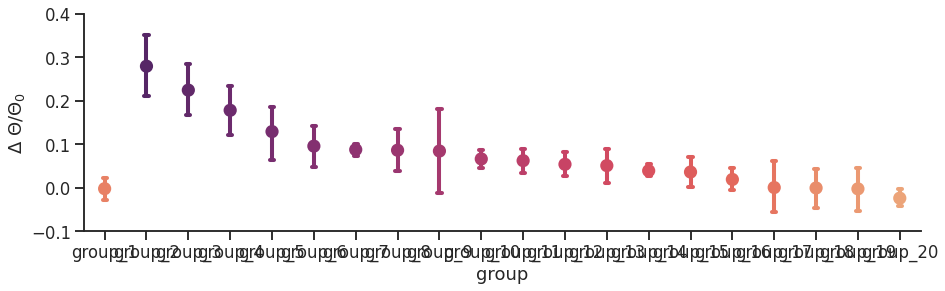

In [ ]:
sns.set(style='ticks', context='talk', )

order = [ 'group_1', 'group_2',
         'group_3', 'group_4', 'group_5', 'group_6',
         'group_7', 'group_8', 'group_9', 'group_10', 'group_11', 'group_12', 'group_13',
         'group_14', 'group_15', 'group_16', 'group_17', 'group_18', 'group_19', 'group_20'
         ]

fig, ax = plt.subplots(figsize=(15, 4))

ax = sns.pointplot(x="group", y="per_change",
                   ci=68, capsize=0.1,
                   data=df4plot, join=False,
                   order=order, palette=my_color_palette)
ax.set(
    ylabel=r'$\Delta$ $\Theta$/$\Theta_0$',
    ylim=[-0.1, 0.4]
)

# plt.axhline(0, color='k', linestyle='--', zorder=0)
sns.despine()

fig_title = 'average_per_change'
base_path = '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/figures/'+ fig_title
base_path = '/content/drive/My Drive/00_project/02_per/4_Ort_RNAi/starved/figures/'+ fig_title

base_path = '/content/drive/My Drive/01_paper/HisCl1/raw_data/figure_3/'+ fig_title
stat_path = base_path +  '_statistics.csv'
fig_path = base_path + '.svg'

plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

plt.show()



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


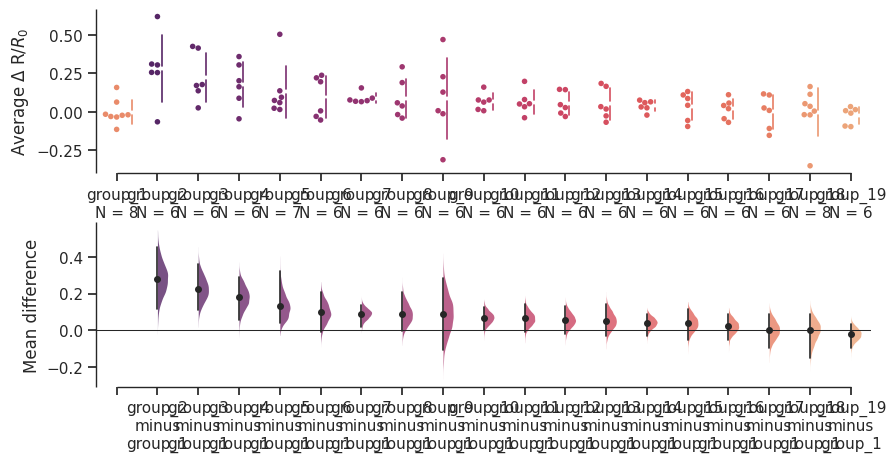

In [ ]:
palette = sns.color_palette('flare_r', 19)

my_color_palette = {
                    'group_1': palette[16],
                    'group_2': palette[0],
                    'group_3': palette[1],
                    'group_4': palette[2],
                    'group_5': palette[3],
                    'group_6': palette[4],
                    'group_7': palette[5],
                    'group_8': palette[6],
                    'group_9': palette[7],
                    'group_10': palette[8],
                    'group_11': palette[9],
                    'group_12': palette[10],
                    'group_13': palette[11],
                    'group_14': palette[12],
                    'group_15': palette[13],
                    'group_16': palette[14],
                    'group_17': palette[15],
                    'group_18': palette[17],
                    'group_19': palette[18],
                        }

multi_groups = dabest.load(df4plot,
                           x="group",
                           y='per_change',
                           idx=(
                                 ('group_1', 'group_2', 'group_3',
                                  'group_4', 'group_5', 'group_6', 'group_7',
                                  'group_8', 'group_9', 'group_10', 'group_11',
                                  'group_12', 'group_13', 'group_14', 'group_15',
                                  'group_16', 'group_17', 'group_18', 'group_19'),

                                #  ('group_5', 'group_6', 'group_7', 'group_8', 'group_9'),
                                #  ('group_10', 'group_11'),
                                #  ('group_12', 'group_13'),
                                #  ('group_14', 'group_15', 'group_16', 'group_17'),
                                #  ('group_18', 'group_19', 'group_20', 'group_21'),
                                #  ('group_22', 'group_23'),
                                #  ('group_24', 'group_25'),

                                 ))
f = multi_groups.mean_diff.plot(
                                swarm_label=r'Average $\Delta$ R/$R_0$',
                                raw_marker_size=4,
                                es_marker_size=4,
                                custom_palette=my_color_palette,
                                fig_size=(10, 5), # W X H
                                group_summary_kwargs = {'lw':1.2},
                                swarm_desat=1,
                                # swarm_ylim = s_ylim,
                                # contrast_ylim = c_ylim,
                                );

fig_title = 'RNAi_per_change'
base_path = '/content/drive/My Drive/00_project/02_per/3_Gr64f_RNAi_screening/'+ fig_title
stat_path = base_path +  '_statistics.csv'
fig_path = base_path + '.svg'

multi_groups.mean_diff.statistical_tests.to_csv(stat_path)

plt.savefig(fig_path, format='svg' , transparent=True, bbox_inches='tight', pad_inches=0.0, dpi=600)

plt.show()

- ATR per_change
(6, 180)


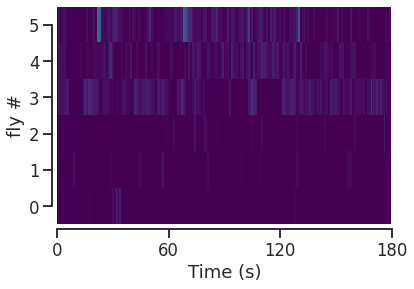

In [ ]:
category = ['- ATR', '+ ATR']
target_cols = ['PER', 'Rostrum', 'Haustellum']
cat = category[0]
t_col = 'per_change'
cond = df['group'] == 'group_1'
pivot = df[cond].pivot('fly #', 'time', t_col)

print(cat, t_col)
print(pivot.shape)

sns.set(style='ticks', context='talk')

fig, ax = plt.subplots()

ax.imshow(pivot, aspect='auto', interpolation='none', vmax=1.0, vmin=0.0, origin='lower', cmap=cm.get_cmap('viridis'))

xticks = [0, 60, 120, 180]
# yticks = np.array([0, num_fly-1])
ax.set(xlabel='Time (s)',
       ylabel='fly #',
       xticks=xticks,
       xlim=[0, 180],
    #    yticks=yticks,
    #    xticklabels=(xticks/20).astype(int),
    #    yticklabels=[1, num_fly]
       )

# ax.axvspan(60, 120, 0, 1, alpha=0.1, color='k', lw=0)
# for i in np.arange(60, 120, 10):
#     ax.axvspan(i, i+0.1, 0, 1, alpha=0.1, color='k')
sns.despine(trim=True, offset=5)

fig_title = g + 'each_temp_activation_per_change_control'
# base_path = '/content/drive/My Drive/00_project/02_per/2_HisCl1-/figures/'+ fig_title
base_path = '/content/drive/My Drive/00_project/02_per/gr64f/GAL4/starved/60s-light-stimulation/{Gr64f}{+};{CsChri-tdT}{TM2}/figures/'+ fig_title
fig_path = base_path + '.svg'

if fig_path:
    plt.savefig(fig_path, transparent=True, dpi=600, bbox_inches='tight', pad_inches=0.0)
plt.show()

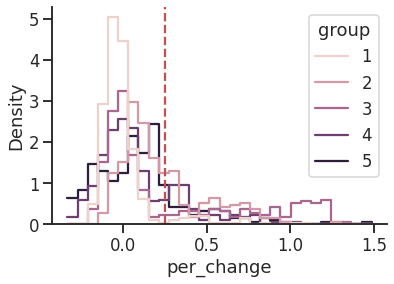

nan


In [ ]:
save_fig_path = '/content/drive/My Drive/00_project/02_per/gr64f/GAL4/starved/60s-light-stimulation/{Gr64f}{+};{CsChri-tdT}{TM2}/figures/density_per_change.svg'

sns.set(style='ticks', context='talk')
sns.histplot(data=df[(df['time'] >=60) & (df['time'] < 120)], x="per_change", bins=30, hue='group', element="step", fill=False, stat='density',common_norm=False)
per_change_quantile = df[(df.group=='- ATR')].per_change.quantile(0.9999)
plt.axvline(0.25, color='r', linestyle='--')
sns.despine()

# if save_fig_path:
#     plt.savefig(save_fig_path, transparent=True, dpi=600, bbox_inches='tight')

plt.show()

print(per_change_quantile)


In [ ]:
# Number of PER for each fly:
# Total length of PER:
# sec/PER (* Activation?):
# PER intensity in the first peak:

In [ ]:
target = 'Rostrum'

# plot params:
x = 'time'
y = target # PER, HRH, RHL
hue = 'group'

# figrue params.:
inch = 25.4
size =  60 / inch # mm
ratio = 1/2
num_fly = 11
vmin = 0
if y == 'PER':
    vmax = 1
    tick_loc = 0.5
    ylabel = 'Fraction'
else:
    vmax = 180
    tick_loc = 60
    ylabel = r'$\angle$ ' + target + ' [$\circ$]'

In [ ]:
dlc_output_path

['/content/drive/My Drive/00_project/02_per/gr66a/GAL4/fed/60s-light-stimulation/{Gr66a}{+};{CsChr-tdT}{TM2}/negative-control/data/deeplabcut/filtered/*.h5',
 '/content/drive/My Drive/00_project/02_per/gr66a/GAL4/fed/60s-light-stimulation/{Gr66a}{+};{CsChr-tdT}{TM2}/experimental/data/deeplabcut/filtered/*.h5']

In [ ]:
# save file:
fname = '{Gr66a}{+};{CsChr-tdT}{TM2}_rostrum_60s.svg'
save_fig_path = '/content/drive/My Drive/00_project/02_per/gr66a/GAL4/fed/60s-light-stimulation/{Gr66a}{+};{CsChr-tdT}{TM2}/figures/' + fname
# save_fig_path = None
print(save_fig_path)

/content/drive/My Drive/00_project/02_per/gr66a/GAL4/fed/60s-light-stimulation/{Gr66a}{+};{CsChr-tdT}{TM2}/figures/{Gr66a}{+};{CsChr-tdT}{TM2}_rostrum_60s.svg


In [ ]:
np.array(sns.color_palette("rocket", 10)[9]) * 255
# sns.color_palette("crest", 3)

array([246.86670105, 200.51813565, 170.27341695])

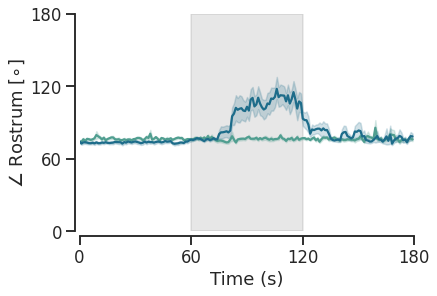

In [ ]:
sns.set(style='ticks', context='talk')

fig, ax = plt.subplots()

color = sns.color_palette("crest", 2)

sns.lineplot(x=x,
             y=y,
             hue=hue,
             ci=68,
            #  palette=['#b7b7b7', '#4285f4'],
             palette=color,
            #  palette=['black'],
             legend=False,
             data=df, ax=ax)


ax.axvspan(60, 120, 0, 1, alpha=0.1, color='k', zorder=0)
# for i in np.arange(60, 120, 10):
#     ax.axvspan(i, i+0.01, 0, 1, alpha=0.5, color='k',  zorder=0)


ax.set(xlabel='Time (s)',
       ylabel=ylabel,
       xlim=[0, 180],
       ylim=[0, vmax])

ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_loc))

sns.despine(trim=True, offset=5)

if save_fig_path:
    plt.savefig(save_fig_path, transparent=True, dpi=600, bbox_inches='tight')

plt.show()

In [ ]:
category = ['- ATR', '+ ATR']
# category = ['-TshGAL80', '+TshGAL80']
target_cols = ['PER', 'Rostrum', 'Haustellum']
cat = category[1]
t_col = target_cols[1]
cond = df['group'] == cat
pivot = df[cond].pivot('fly #', 'time', t_col)

print(cat, t_col)
print(pivot.shape)

+ ATR Rostrum
(12, 180)


In [ ]:
# figrue params.:
inch = 25.4
size =  60 / inch # mm
ratio = 1/1.8
num_fly = pivot.shape[0]
vmin = 80
if t_col == 'PER':
    vmax = 1
else:
    vmax = 120


In [ ]:
# save file:
# fname = 'Indivisual_' + cat + '_' + target + '_' + GenoType + '.svg'
# save_fig_path = BaseDir + ProjectDir + GenoType + '/figures/' + fname

fname = 'each_rostrum_aatr.svg'
save_fig_path = '/content/drive/My Drive/00_project/02_per/gr66a/GAL4/fed/60s-light-stimulation/{Gr66a}{+};{CsChr-tdT}{TM2}/figures/' + fname

# save_fig_path = None
print(save_fig_path)

/content/drive/My Drive/00_project/02_per/gr66a/GAL4/fed/60s-light-stimulation/{Gr66a}{+};{CsChr-tdT}{TM2}/figures/each_rostrum_aatr.svg


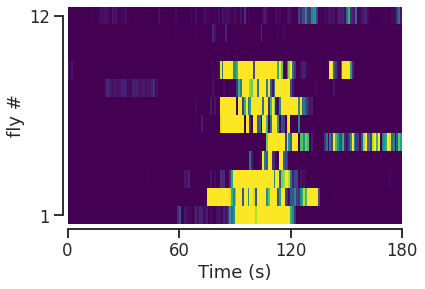

In [ ]:
sns.set(style='ticks', context='talk')

fig, ax = plt.subplots()

ax.imshow(pivot, aspect='auto', interpolation='nearest', origin='lower', norm=colors.Normalize(vmin=vmin, vmax=vmax), cmap=cm.get_cmap('viridis'))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1200))
# xticks = np.array(ax.get_xticks()[1:])
# print(xticks)
xticks = [0, 60, 120, 180]
yticks = np.array([0, num_fly-1])
ax.set(xlabel='Time (s)',
       ylabel='fly #',
       xticks=xticks,
       xlim=[0, 180],
       yticks=yticks,
    #    xticklabels=(xticks/20).astype(int),
       yticklabels=[1, num_fly])

sns.despine(trim=True, offset=5)

if save_fig_path:
    plt.savefig(save_fig_path, transparent=True, dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# save file:
# fname = 'Bar_' + target + '_' + GenoType + '.jpg'
# save_fig_path = BaseDir + ProjectDir + GenoType + '/figures/' + fname
fname = 'cbar.svg'
save_fig_path = '/content/drive/My Drive/00_project/02_per/0_GRs/60s-lit/{Gr64fG4}{+};{CsChr-mCh}{+}/figures/' + fname

# save_fig_path = None
print(save_fig_path)

/content/drive/My Drive/00_project/02_per/0_GRs/60s-lit/{Gr64fG4}{+};{CsChr-mCh}{+}/figures/cbar.svg


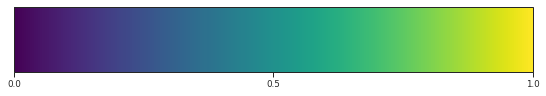

In [ ]:
a = np.array([[0,1]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap="viridis")
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation="horizontal", ticks=[0, 0.5, 1], cax=cax)

fig_title = 'colorbar'
base_path = '/content/drive/My Drive/00_project/02_per/gr64f/GAL4/starved/60s-light-stimulation/{Gr64f}{+};{CsChri-tdT}{TM2}/figures/'+ fig_title
fig_path = base_path + '.svg'

if fig_path:
    plt.savefig(fig_path, transparent=True, dpi=600, bbox_inches='tight', pad_inches=0.0)
plt.show()

In [ ]:
vmin = 0
vmax = 1

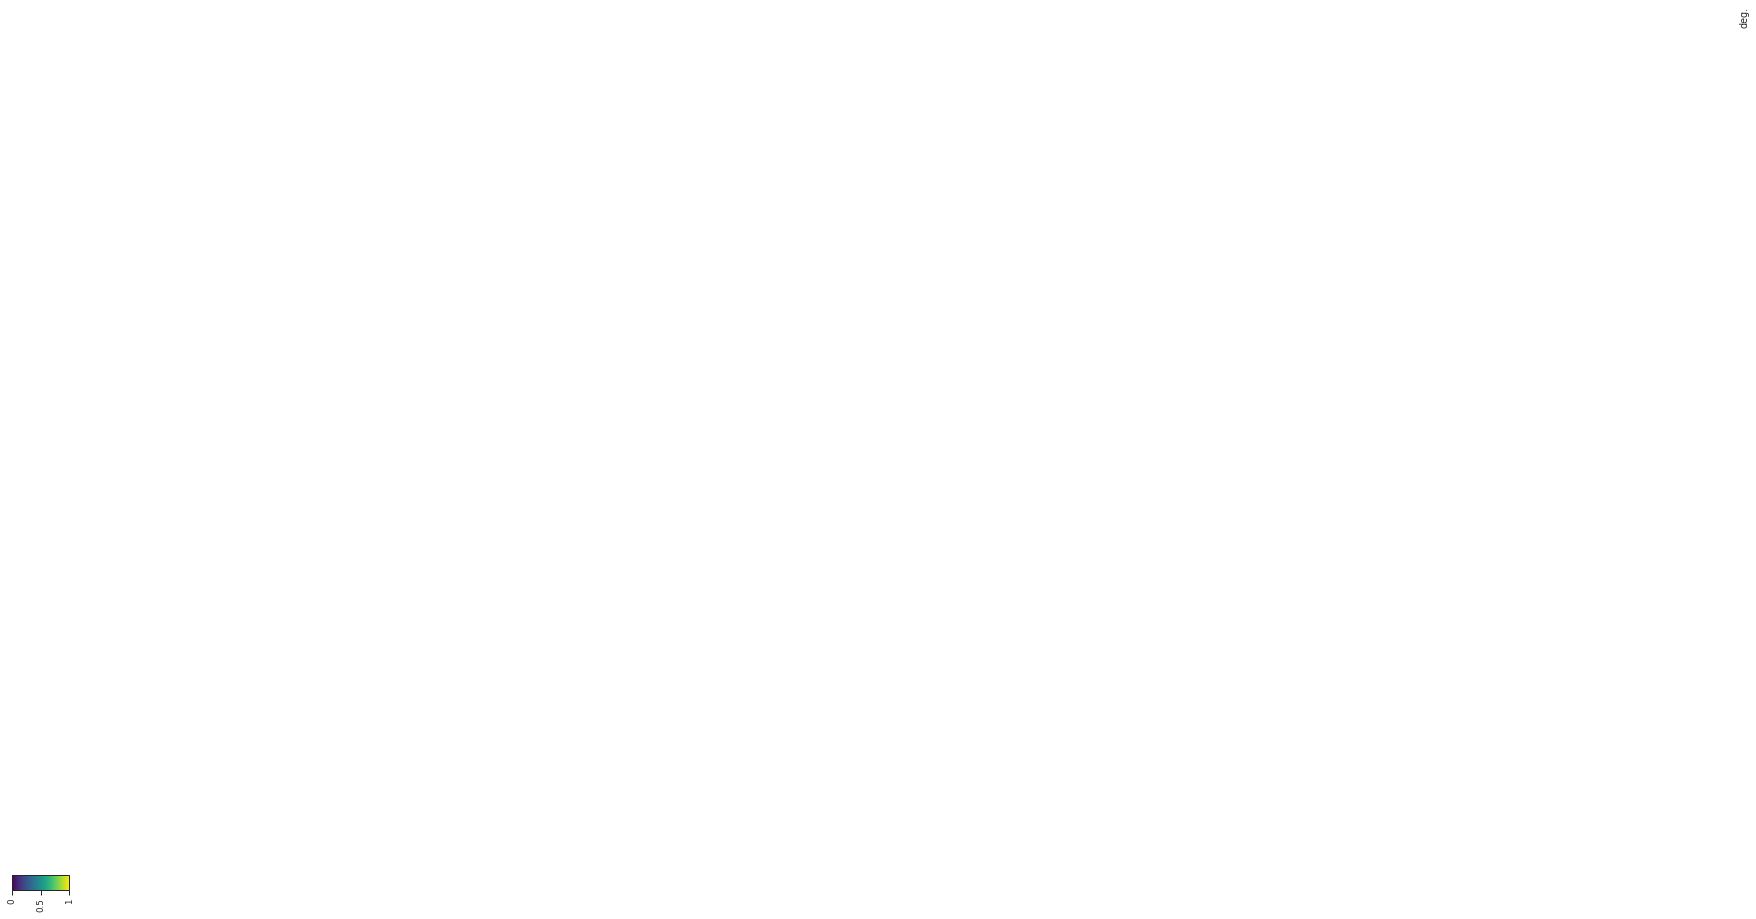

In [ ]:
# Color bar
sns.set(style='ticks', context='paper')
cbar = np.array([[vmin, vmax]])
fig, ax = plt.subplots(figsize=(1, 2))
# fig, ax = plt.subplots(figsize=(1, 1))
bar = ax.imshow(cbar, cmap=plt.cm.get_cmap('viridis'))
# bar = ax.imshow(cbar, cmap=plt.cm.get_cmap('viridis', 3))
plt.gca().set_visible(False)
cbar_ax = fig.add_axes([0.1, 0.2, 0.8, 0.1]) # [left, bottom, width, height]\
cbar = fig.colorbar(bar,
                    orientation="horizontal",
                    norm=colors.Normalize(vmin=vmin, vmax=vmax),
                    # boundaries=[0, 0.33, 0.66,  1],
                    ticks=[0, 0.5, 1],
                    # ticks=[0, 0.5, 1],
                    cax=cbar_ax)
# cbar.ax.set_xticklabels(['none', 'partial', 'full'], rotation=90)
cbar.ax.set_xticklabels(['0', '0.5', '1'], rotation=90)
cbar.ax.text(30, 60, 'deg.', rotation=90)
# cbar.ax.text(-0.5, 0.5, 'PER', rotation=90)
# if save_fig_path:
#     plt.savefig(save_fig_path, transparent=True, dpi=600)
plt.show()